In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.0 MB/s eta 0:00:00


In [3]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [4]:
import tensorflow as tf

In [5]:
# Import libraries
import sys
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [6]:
train_original_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_train_original.npy')
train_mask_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_train_mask.npy')
validation_original_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_validation_original.npy')
validation_mask_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_validation_mask.npy')
test_original_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_test_original.npy')
test_mask_2D = np.load('/content/drive/MyDrive/2DPart/2Dnpy/2D_test_mask.npy')

In [6]:
print("Shape of the data:", train_original_2D.shape)
print("Shape of the data:", train_mask_2D.shape)

Shape of the data: (470, 512, 512, 3)
Shape of the data: (470, 512, 512, 2)


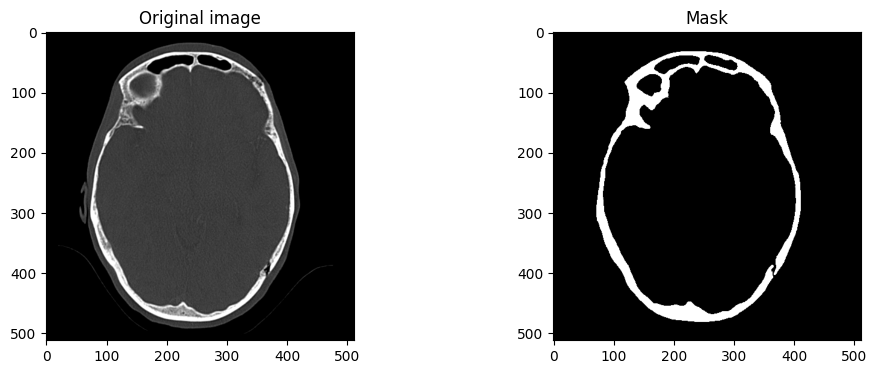

In [7]:
# Check the images 2D
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].imshow(train_original_2D[467,:,:,0], cmap='gray')
axes[0].set_title('Original image')

axes[1].imshow(train_mask_2D[467,:,:,0], cmap='gray')
axes[1].set_title('Mask')

plt.show()

In [7]:
LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)

In [8]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [9]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

In [10]:
# others: vgg16, resnet50
backbone = 'vgg16' #resnet50, vgg16
preprocess_input = sm.get_preprocessing(backbone)

In [11]:
train_original_2D = preprocess_input(train_original_2D)
validation_original_2D = preprocess_input(validation_original_2D)
test_original_2D = preprocess_input(test_original_2D)

In [12]:
# Define the model
model = sm.Unet(backbone, classes=2,
                input_shape=(512, 512, 3),
                encoder_weights='imagenet',
                activation='sigmoid')

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 512, 512, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 512, 512, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)         0         ['block1_conv2[0][0]']        
                             

In [13]:
from tensorflow.keras.callbacks import Callback

In [14]:
class SavePredictionsCallback(Callback):
    def __init__(self, validation_data, save_dir):
        super(SavePredictionsCallback, self).__init__()
        self.validation_data = validation_data
        self.save_dir = save_dir

    def on_epoch_end(self, epoch, logs=None):
        predicted_masks = self.model.predict(self.validation_data[0])

        for i in range(len(self.validation_data[0])):
            self.save_or_visualize_results(
                self.validation_data[0][i],
                self.validation_data[1][i],
                predicted_masks[i],
                epoch,
                i
            )

    def save_or_visualize_results(self, input_image, true_mask, predicted_mask, epoch, sample_idx):
        fig, axes = plt.subplots(1, 3, figsize=(12, 4))

        axes[0].imshow(input_image[:,:,0], cmap='gray')
        axes[0].set_title('Input Image')

        axes[1].imshow(true_mask[:,:,0], cmap='gray')
        axes[1].set_title('True Mask')

        axes[2].imshow(predicted_mask[:,:,0], cmap='gray')
        axes[2].set_title('Predicted Mask')

        plt.savefig(os.path.join(self.save_dir, f'epoch_{epoch}_sample_{sample_idx}.png'))
        plt.close()

In [15]:
save_dir_resn = '/content/drive/MyDrive/2DPart/Model_training_prediction/resnet50'
save_dir_vgg = '/content/drive/MyDrive/2DPart/Model_training_prediction/vgg16'
os.makedirs(save_dir_vgg, exist_ok=True) # save_dir_vgg, save_dir_resn

save_predictions_callback = SavePredictionsCallback(validation_data=(validation_original_2D, validation_mask_2D),
                                                    save_dir=save_dir_vgg) # save_dir_vgg, save_dir_resn

In [16]:
history=model.fit(train_original_2D,
          train_mask_2D,
          batch_size=10,
          epochs=50,
          verbose=1,
          validation_data=(validation_original_2D, validation_mask_2D),
          callbacks=[save_predictions_callback])

Epoch 1/50
 6/47 [==>...........................] - ETA: 6s - loss: 0.6179 - iou_score: 0.4707 - f1-score: 0.5325

47/47 [==============================] - 138s 2s/step - loss: 0.4930 - iou_score: 0.6587 - f1-score: 0.7549 - val_loss: 0.5309 - val_iou_score: 0.4673 - val_f1-score: 0.6316
Epoch 2/50
47/47 [==============================] - 91s 2s/step - loss: 0.3479 - iou_score: 0.8374 - f1-score: 0.9091 - val_loss: 0.3337 - val_iou_score: 0.8119 - val_f1-score: 0.8931
Epoch 3/50
47/47 [==============================] - 91s 2s/step - loss: 0.2770 - iou_score: 0.8817 - f1-score: 0.9348 - val_loss: 0.2674 - val_iou_score: 0.8445 - val_f1-score: 0.9119
Epoch 4/50
47/47 [==============================] - 91s 2s/step - loss: 0.2274 - iou_score: 0.8986 - f1-score: 0.9447 - val_loss: 0.2283 - val_iou_score: 0.8633 - val_f1-score: 0.9229
Epoch 5/50
47/47 [==============================] - 88s 2s/step - loss: 0.1892 - iou_score: 0.9076 - f1-score: 0.9500 - val_loss: 0.2228 - val_iou_score: 0.8662 - val_f1-score: 0.9247
Epoch 6/50
47/47 [==============================] - 89s 2s/step - loss: 0.1611 - iou_score

In [17]:
model.save('/content/drive/MyDrive/2DPart/2Dmodel/vgg16_totalLoss_2D.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


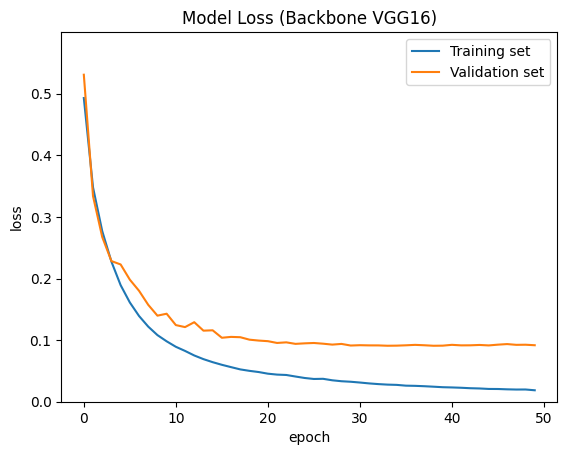

In [19]:
# Plot loss function
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.ylim(0, 0.6)
plt.yticks(np.arange(0, 0.6, 0.1))
plt.title('Model Loss (Backbone VGG16)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')